# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [83]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
from copy import deepcopy
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [11]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, label=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well, label)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None, label=None):

        if label is not None:
            if not isinstance(label, list):
                label = [label]
            return self.df[self.df.label.isin(label)].reset_index(drop=True)
            
        if well is not None:
            return self.df[self.df['well']==well].reset_index(drop=True)
        
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [12]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_eda.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_eda.pkl', 'wb') as f:
      pickle.dump(dset, f)

In [16]:
dset.df

,origin,well,ts,label,path,nlines
0,R,1.0,2017-02-01 02:02:07,0,..\dataset\0\WELL-00001_20170201020207.csv,17874
1,R,1.0,2017-02-01 07:01:14,0,..\dataset\0\WELL-00001_20170201070114.csv,17927
2,R,1.0,2017-02-01 12:01:24,0,..\dataset\0\WELL-00001_20170201120124.csv,17917
3,R,1.0,2017-02-01 17:03:11,0,..\dataset\0\WELL-00001_20170201170311.csv,17810
4,R,1.0,2017-02-01 22:02:28,0,..\dataset\0\WELL-00001_20170201220228.csv,17853
...,...,...,...,...,...,...
1976,S,NaN,NaT,8,..\dataset\8\SIMULATED_00077.csv,26999
1977,S,NaN,NaT,8,..\dataset\8\SIMULATED_00078.csv,26999
1978,S,NaN,NaT,8,..\dataset\8\SIMULATED_00079.csv,26999
1979,S,NaN,NaT,8,..\dataset\8\SIMULATED_00080.csv,26999


In [ ]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']

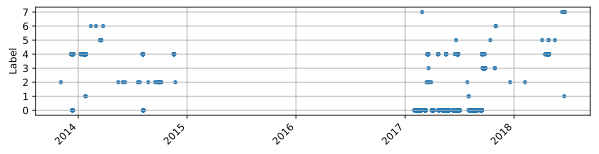

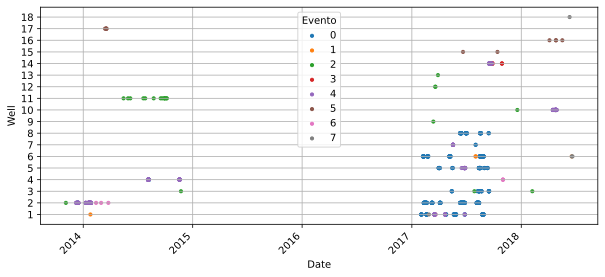

In [115]:
data_df = dset.df[dset.df.origin=='R']
data_df = data_df.sort_values(['label', 'ts']).reset_index(drop=True)

plt.figure(figsize=(10, 2))
plt.scatter(x=data_df.ts, y=data_df.label.apply(str), s=10)
plt.xticks(rotation = 45, ha="right")
plt.ylabel('Label')
plt.grid()

data_df = data_df.sort_values(['well', 'ts']).reset_index(drop=True)

plt.figure(figsize=(10, 4))
for i in range(8):
    tmp = data_df[data_df.label==i]
    plt.scatter(x=tmp.ts, y=tmp.well.astype(int).astype(str), s=10, label=str(i))
plt.xticks(rotation = 45, ha="right")
plt.ylabel('Well')
plt.xlabel('Date')
plt.legend(loc='upper center', title='Evento')
plt.grid()

plt.show()

In [58]:
from IPython.display import display, HTML

tmp = dset.df[['origin', 'label', 'path']].groupby(['origin', 'label']).count().reset_index()
tmp = tmp.pivot(index='origin', columns='label', values='path').fillna(0).astype(int).reindex(["R", "S", "D"])
# tmp.index = ['']
# tmp.columns = ['files']
display(HTML(tmp.to_html()))

label,0,1,2,3,4,5,6,7,8
origin,,,,,,,,,
R,597,5,22,32,344,12,6,4,0
S,0,114,16,74,0,439,215,0,81
D,0,10,0,0,0,0,0,10,0


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [88]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def stats(self):
        flista = flist + [self.target]
        count_dict = defaultdict(list)
        for label, p in zip(self.dset['label'], self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            count_dict['rcount'].append(len(dfo.index))
            count_dict['label'].append(label)
            for f in flista:
                count_dict[f].append(np.sum(dfo[f].isna()))
        return count_dict    
        
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [99]:
gen = CustomGen(dset.real, flist, 'class')
st = gen.stats()

In [100]:
st = pd.DataFrame.from_dict(st)
st = st.groupby('label').sum().reset_index()
for f in flist+['class']:
    st[f] = st[f]/st['rcount']*100
st

,label,rcount,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
0,0,9956791,0.035734,0.035734,0.035865,10.134540,14.785436,25.627142,100.0,25.482819,0.000000
1,1,118294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0,0.000000,0.861413
2,2,158680,0.388203,0.388203,0.388203,69.854424,86.659314,90.005672,100.0,86.659314,0.646584
3,3,569152,0.102082,0.102082,0.102082,0.118422,0.095581,0.120706,100.0,0.097513,0.000000
4,4,2462076,0.030787,0.043337,0.042891,0.027294,0.045734,50.508961,100.0,23.541475,0.000000
5,5,361998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0,0.000000,0.403593
6,6,54212,0.000000,0.000000,0.000000,0.000000,0.000000,11.700362,100.0,11.700362,1.147347
7,7,271708,0.133231,0.133231,0.133231,0.133231,0.133231,0.133231,100.0,0.133231,0.232971


In [113]:
print(st.to_latex(float_format=lambda x: '%.2f' % x, index=False))

\begin{tabular}{rrrrrrrrrrr}
\toprule
 label &  rcount &  P-PDG &  P-TPT &  T-TPT &  P-MON-CKP &  T-JUS-CKP &  P-JUS-CKGL &  T-JUS-CKGL &   QGL &  class \\
\midrule
     0 & 9956791 &   0.04 &   0.04 &   0.04 &      10.13 &      14.79 &       25.63 &      100.00 & 25.48 &   0.00 \\
     1 &  118294 &   0.00 &   0.00 &   0.00 &       0.00 &       0.00 &        0.00 &      100.00 &  0.00 &   0.86 \\
     2 &  158680 &   0.39 &   0.39 &   0.39 &      69.85 &      86.66 &       90.01 &      100.00 & 86.66 &   0.65 \\
     3 &  569152 &   0.10 &   0.10 &   0.10 &       0.12 &       0.10 &        0.12 &      100.00 &  0.10 &   0.00 \\
     4 & 2462076 &   0.03 &   0.04 &   0.04 &       0.03 &       0.05 &       50.51 &      100.00 & 23.54 &   0.00 \\
     5 &  361998 &   0.00 &   0.00 &   0.00 &       0.00 &       0.00 &        0.00 &      100.00 &  0.00 &   0.40 \\
     6 &   54212 &   0.00 &   0.00 &   0.00 &       0.00 &       0.00 &       11.70 &      100.00 & 11.70 &   1.15 \\
     7 & 

C:\Users\Asus\AppData\Local\Temp\ipykernel_24516\1708859979.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(st.to_latex(float_format=lambda x: '%.2f' % x, index=False))


In [76]:
pd.DataFrame.from_dict(st, orient='index')

,0
rcount,13952911
P-PDG,5875
P-TPT,6184
T-TPT,6186
P-MON-CKP,1121628
T-JUS-CKP,1611698
P-JUS-CKGL,3945423
T-JUS-CKGL,13952911
QGL,3261651
class,4761


In [8]:
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2013-12-09 05:00:00 {'P-PDG': nan, 'P-TPT': 1.0689456673425932, 'T-TPT': -0.9444546644711171, 'P-MON-CKP': 0.09582108322486568, 'T-JUS-CKP': -0.9958246164193104, 'P-JUS-CKGL': -1.7725572725484982, 'T-JUS-CKGL': nan, 'QGL': nan} 4.0
3 2013-12-09 05:01:00 {'P-PDG': nan, 'P-TPT': 1.201075578119019, 'T-TPT': -1.6301541431155548, 'P-MON-CKP': -2.2361080103006716, 'T-JUS-CKP': -0.9958246164193104, 'P-JUS-CKGL': -1.74203817125606, 'T-JUS-CKGL': nan, 'QGL': nan} 4.0
3 2013-12-09 05:02:00 {'P-PDG': nan, 'P-TPT': -1.6548721236820316, 'T-TPT': -0.7753868667243752, 'P-MON-CKP': -0.43277726953755935, 'T-JUS-CKP': -0.9958246164193104, 'P-JUS-CKGL': -1.7115193301978668, 'T-JUS-CKGL': nan, 'QGL': nan} 4.0
3 2013-12-09 05:03:00 {'P-PDG': nan, 'P-TPT': -2.209251944219409, 'T-TPT': 0.6402673183513238, 'P-MON-CKP': 0.484470007376251, 'T-JUS-CKP': -0.9958246164193104, 'P-JUS-CKGL': -1.6809997084369352, 'T-JUS-CKGL': nan, 'QGL': nan} 4.0


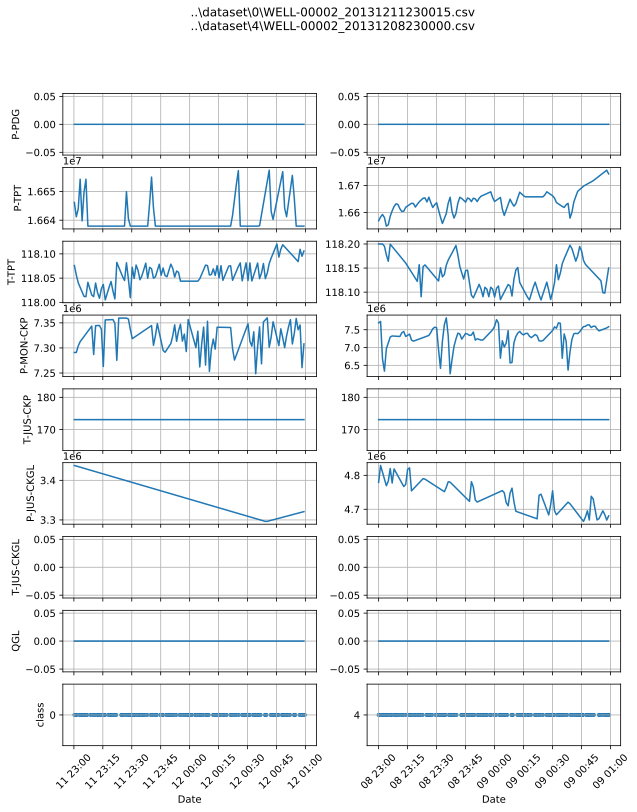

In [9]:
gen.plot([8, 0])
plt.savefig('plot.jpg')